### Import Libraries

In [1]:
#Import libraries
import yfinance as yf
from causalimpact import CausalImpact 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Suppress Warning

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


### Define Dates

In [2]:
#Define Dates. 
#Flight 302 crashed on March 10, 2019 on a weekend. We are evaluating how that impacted stock price from 11th March

training_start = "2018-12-03"
training_end = "2019-03-08"
treatment_start = "2019-03-11"
treatment_end = "2019-03-20"
end_stock = "2019-03-21"

### Download Stock Data from Yahoo Finance

In [3]:
#Boeing Data

y = ["BA"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y['Adj Close'].rename("y")
y[:5]

[*********************100%***********************]  1 of 1 completed


Date
2018-12-03    349.772003
2018-12-04    332.806152
2018-12-06    322.506165
2018-12-07    314.071869
2018-12-10    317.113251
Name: y, dtype: float64

### Additional Stocks will be our Covariates or Control Group

In [4]:
#Load more stock data

stocks = ["CARL-B.CO", "ZAL.DE", "SQ", "AIR", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")
X.head()

[*********************100%***********************]  9 of 9 completed


Adj Close                                                       \
                  AIR   CARL-B.CO          DE       GOOG         JD   KTOS   
Date                                                                         
2018-12-03  44.194572  657.508606  152.174301  55.321499  21.468348  13.42   
2018-12-04  41.431175  663.102112  142.211365  52.541000  20.922129  12.81   
2018-12-05        NaN  658.591187         NaN        NaN        NaN    NaN   
2018-12-06  41.025082  642.712830  144.838104  53.436501  20.707542  13.74   
2018-12-07  40.529850  645.419434  138.149200  51.828999  20.414927  13.64   

                                                 Close  ...       Open  \
                   SQ       TRMB     ZAL.DE        AIR  ...     ZAL.DE   
Date                                                    ...              
2018-12-03  71.949997  39.240002  27.740000  44.619999  ...  28.000000   
2018-12-04  63.509998  37.060001  26.950001  41.830002  ...  27.650000   
2018-12-05        NaN        NaN  26.350000        NaN  ...  26.910000   
2018-12-06  65.690002  36.919998  25.450001  41.419998  ...  26.059999   
2018-12-07  60.779999  35.490002  25.510000  40.919998  ...  25.709999   

              Volume                                                          \
                 AIR CARL-B.CO         DE        GOOG          JD       KTOS   
Date                                                                           
2018-12-03  185800.0  249827.0  5132000.0  39824000.0  19812700.0   844500.0   
2018-12-04  161900.0  282413.0  3549300.0  46904000.0  18051400.0  2153300.0   
2018-12-05       NaN  155302.0        NaN         NaN         NaN        NaN   
2018-12-06  254400.0  315851.0  4595900.0  55384000.0  20377400.0  3009200.0   
2018-12-07  170700.0  198150.0  3005600.0  42024000.0  13522900.0  1687100.0   

                                             
                    SQ       TRMB    ZAL.DE  
Date                                         
2018-12-03  16208500.0  1574100.0  422706.0  
2018-12-04  31179700.0   973900.0  427882.0  
2018-12-05         NaN        NaN  532466.0  
2018-12-06  23253600.0  1726600.0  715097.0  
2018-12-07  20672200.0  1055500.0  564953.0  

[5 rows x 54 columns]

### Combine all stocks into one DataFrame 

In [18]:
#Getting just the adjusted close

X = X.iloc[:,:len(stocks)]
X.head(5)

,AIR,CARL-B.CO,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2018-12-03,44.194572,657.508606,152.174301,55.321499,21.468348,13.42,71.949997,39.240002,27.740000
2018-12-04,41.431175,663.102112,142.211365,52.541000,20.922129,12.81,63.509998,37.060001,26.950001
2018-12-05,NaN,658.591187,NaN,NaN,NaN,NaN,NaN,NaN,26.350000
2018-12-06,41.025082,642.712830,144.838104,53.436501,20.707542,13.74,65.690002,36.919998,25.450001
2018-12-07,40.529850,645.419434,138.149200,51.828999,20.414927,13.64,60.779999,35.490002,25.510000


In [6]:
#Removing One level

X.columns = X.columns.droplevel()
X.head(1)

,AIR,CARL-B.CO,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2018-12-03,44.194572,657.508606,152.174301,55.321499,21.468348,13.42,71.949997,39.240002,27.74


In [7]:
#Combine everything

X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,AIR,CARL-B.CO,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2018-12-03,349.772003,44.194572,657.508606,152.174301,55.321499,21.468348,13.42,71.949997,39.240002,27.740000
2018-12-04,332.806152,41.431175,663.102112,142.211365,52.541000,20.922129,12.81,63.509998,37.060001,26.950001
2018-12-06,322.506165,41.025082,642.712830,144.838104,53.436501,20.707542,13.74,65.690002,36.919998,25.450001
2018-12-07,314.071869,40.529850,645.419434,138.149200,51.828999,20.414927,13.64,60.779999,35.490002,25.510000
2018-12-10,317.113251,40.460518,641.630188,137.933456,51.977501,20.005262,14.57,63.380001,35.650002,25.440001


In [8]:
#Prepara Dataframe with only Training Data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AIR,CARL-B.CO,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2019-03-04,422.555725,34.934994,733.111267,156.370956,57.389999,28.179033,16.510000,74.690002,40.250000,32.110001
2019-03-05,420.045898,34.954842,734.374268,152.249969,58.101501,28.627714,16.850000,76.040001,39.990002,32.730000
2019-03-06,414.518494,34.061619,737.441772,149.222900,57.893002,28.315590,16.620001,75.139999,39.389999,34.130001
2019-03-07,412.662964,33.446281,742.493958,149.015411,57.165001,27.154875,16.389999,74.110001,38.369999,33.820000
2019-03-08,412.643463,33.436359,742.493958,149.948975,57.116001,26.384315,16.280001,74.400002,38.139999,32.810001


### Test Data for Stationarity

In [9]:
#Stationarity
#Perform Adfuller as Correlation Test

from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]
print(test)

#ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

0.9488266659712594
The Time Series is not stationary


In [29]:
#Differencing: Transform data to improve correlation

differencing = df_training.pct_change().dropna()
differencing.head()

,y,AIR,CARL-B.CO,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2018-12-04,-0.048505,-0.062528,0.008507,-0.065471,-0.050261,-0.025443,-0.045455,-0.117304,-0.055556,-0.028479
2018-12-06,-0.030949,-0.009802,-0.030748,0.018471,0.017044,-0.010256,0.072599,0.034325,-0.003778,-0.055659
2018-12-07,-0.026152,-0.012071,0.004211,-0.046182,-0.030082,-0.014131,-0.007278,-0.074745,-0.038732,0.002358
2018-12-10,0.009684,-0.001711,-0.005871,-0.001562,0.002865,-0.020067,0.068182,0.042777,0.004508,-0.002744
2018-12-11,-0.013237,-0.002693,0.010967,-0.000204,0.011736,0.019503,0.005491,-0.025245,-0.015147,0.026730


In [11]:
#Adfuller on differenced data

test = adfuller(x = differencing.y)[1]
print(test)

#ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

0.009805516945452829
The Time Series is stationary


### Pick stocks that are correlated

<AxesSubplot:>

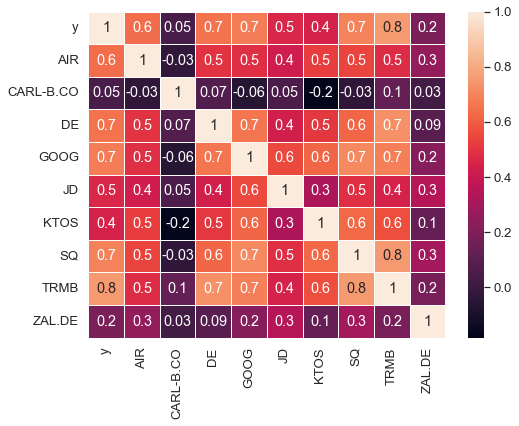

In [12]:
#Correlation matrix

plt.figure(figsize = (8,6))
sns.set(font_scale=1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            linewidths = 1,
            linecolor = 'white')

### Drop Stocks that are not Correlated 

In [13]:
#Prepare the dataset

df_final = df.drop(columns = ["CARL-B.CO", "ZAL.DE","KTOS"])
df_final.head(3)

,y,AIR,DE,GOOG,JD,SQ,TRMB
Date,,,,,,,
2018-12-03,349.772003,44.194572,152.174301,55.321499,21.468348,71.949997,39.240002
2018-12-04,332.806152,41.431175,142.211365,52.541000,20.922129,63.509998,37.060001
2018-12-06,322.506165,41.025082,144.838104,53.436501,20.707542,65.690002,36.919998


In [14]:
#Prepare pre and post period

pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

### Run Google Causal Impact

<Figure size 576x432 with 0 Axes>

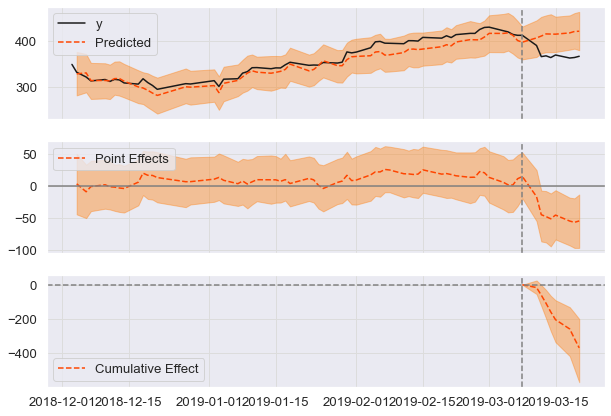

In [19]:
#Google Causal Impact

impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

### Summary

In [17]:
#Summary

print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    369.48             2955.83
Prediction (s.d.)         422.58 (12.59)     3380.65 (100.73)
95% CI                    [397.63, 446.98]   [3181.03, 3575.87]

Absolute effect (s.d.)    -53.1 (12.59)      -424.83 (100.73)
95% CI                    [-77.51, -28.15]   [-620.04, -225.2]

Relative effect (s.d.)    -12.57% (2.98%)    -12.57% (2.98%)
95% CI                    [-18.34%, -6.66%]  [-18.34%, -6.66%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [16]:
#Summary report

print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 369.48. By contrast, in the absence of an
intervention, we would have expected an average response of 422.58.
The 95% interval of this counterfactual prediction is [397.63, 446.98].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -53.1 with a 95% interval of
[-77.51, -28.15]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2955.83.
By contrast, had the intervention not taken place, we would have expected
a sum of 3380.65. The 95% interval of this prediction is [3181.03, 3575.87].


The above results are given in terms of absolute numbers. In relative
terms, the respo